### Giacomo Zema
### s269614
### Homework 3

In [1]:
import networkx as nx
import numpy as np
from numpy.random import choice, rand 
import matplotlib.pyplot as plt
import math
import time
import copy as cp
from sklearn.model_selection import ParameterGrid

#### Problem 1

#### 1.1

Simulate an epidemic on a symmetrix k-regular graph $G=(V, E)$, with $|V|=500$ nodes and $k=4$

Let $\beta=0.3$ and $\rho=0.7$

With one week being one unit of time, simulate the epidemic for 15 weeks.
Start from an initial configuration with 10 infected nodes selected at random from the node set $V$

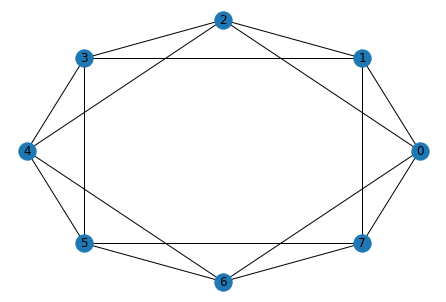

In [2]:
#define a function that builds a k_regular graph with k and N as inputs

def K_regular(N,k):
    nodes = [i for i in range(N)]
    edges = [(i, j % N) for i in range(N) for j in range(i - k // 2, i + k // 2) if i != j]
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

G=K_regular(8,4)

nx.draw_circular(G,with_labels=True)

We simulate a SIR epidemic model in discrete time, one unit of time corresponds to one week.
For every simulation we start by infecting 10 nodes at random with a uniform probability, these are the patients zero of the epidemic.

After the first infection, for each unit of time we we update the state of each node.

One possible transition is from Susceptible to Infected. The probability that one node becomes infected is computed considering the number of nodes that it has been in contact with (neighbors of that node) and the probability that the infection is spread from an infected node to another when they come into contact, which is $\beta\in[0, 1]$. 

So for each node i the graph the probability that it will change its state from Susceptible to Infected at time step t is given by the formula:

$$ P(X_i(t+1)=I|X_i(t)=S)=1-(1-\beta)^m    $$
Where m is the number of infected neighbors of node i at time t

The other possible transition is from Infected to Removed, when an individual recovers from the disease. The probability that at time t an Infected individual recovers from the disease is given by the formula:

$$ P(X_i(t+1)=R|X_i(t)=I)=\rho $$

Knowing this, at each time step we compute the probabilities that each node gets infected if it is Susceptible or that it recovers if it is Infected and change the state of the nodes according to these values.

So at each time step corresponds a new configuration which will determine the probabilities for the transitions at the next time step.


In [3]:
G = K_regular(500, 4)
beta = 0.3
rho = 0.7
steps = 15
runs = 100
first_infections = 10

#this data structure will contain the evolutions of the network over the time steps
#across all runs
states = np.zeros((runs, steps+1, len(G.nodes)))

for run in range(runs):
    #initialize the states of all the individuals to S
    node_state = np.zeros(len(G.nodes))
    #select a random configuration with 10 infected nodes
    infected = np.zeros(first_infections)
    infected = choice(list(G.nodes), first_infections, replace=False)
    node_state[infected]=1
    #starting configuration for the matrix of the current run
    states[run,0]=node_state
    
    for step in range(1, steps+1):
        
        #generate a transition matrix
        prob=np.zeros((len(G.nodes), 3))
        for i in range(len(node_state)):
            if node_state[i]==0:
                #if node is susceptible
                n_i = (node_state[list(G.neighbors(i))] == 1).sum()#number of neighbors of node i
                prob[i][0] = (1-beta)**n_i
                prob[i][1] = 1-prob[i][0]
            elif node_state[i] == 1:
                #if node is infected
                prob[i][1]=1-rho
                prob[i][2]=rho
            else:
                #if the node is removed it stays removed
                prob[i][2]=1
                
        node_state=np.array([choice(3, p=row) for row in prob])
        states[run, step] = node_state
        
        


In [4]:
def plot(matrix):
        #compute the mean over all the runs
        new_infected = np.mean([np.logical_and(matrix[:, i-1] == 0, matrix[:, i] == 1).sum(axis = 1) for i in range(1, steps+1)], axis = 1)
        new_infected = np.append(first_infections,new_infected)
        susceptibles = [(matrix[:,w] == 0).sum()/runs for w in range(steps+1)]
        infected = [(matrix[:,w] == 1).sum()/runs for w in range(steps+1)]
        recovered = [(matrix[:,w] == 2).sum()/runs for w in range(steps+1)]
        
        plt.figure(1, figsize=(10,8))
        plt.plot(new_infected,color="red",label="newly infected", marker='o')
        plt.xlabel("weeks")
        plt.legend()
        plt.grid()
        plt.title("Average newly infected per week")
        
        plt.figure(2, figsize=(10,8))
        plt.xlabel("weeks")
        plt.plot(susceptibles, color="orange",label= "S", marker='o')
        plt.plot(infected, color="red",label = "I", marker='o')
        plt.plot(recovered, color="green",label = "R", marker='o')

        plt.legend()
        plt.grid()
        plt.title("Average total number of S, I, R individuals per week")

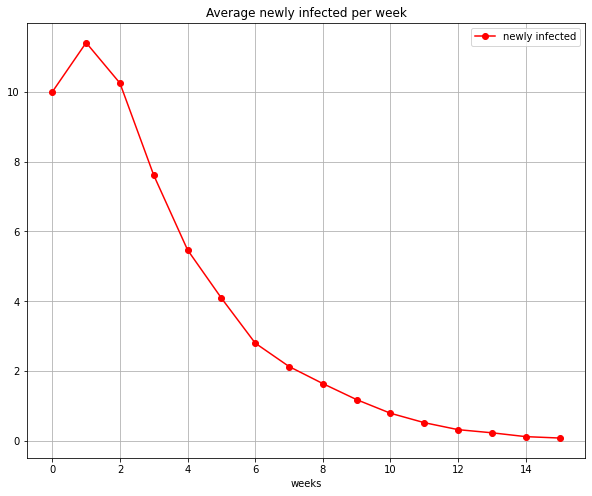

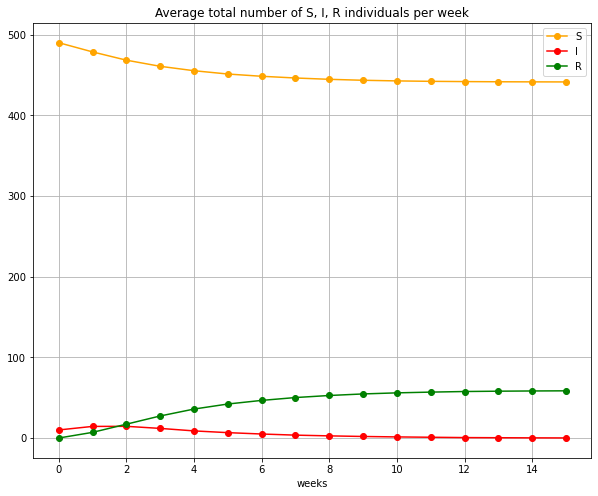

In [5]:
plot(states)

#### 1.2

By using preferencial attachment, generate a random graph of a large size, with average degree $k\in\mathbb{Z}^+$

Let the initial graph be a complete graph with $|V_1|=k_0=k+1$ nodes.

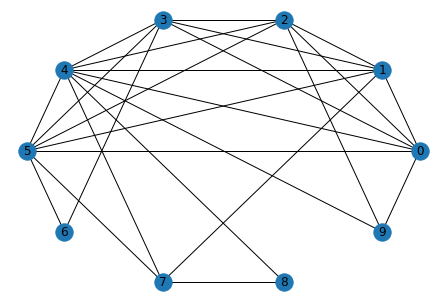

In [6]:
def random_graph(k, n_nodes):
    
    #set a fixed seed so I have the same graph across all runs in point 4
    #the variability made it difficult to estimate parameters
    #the idea is that by setting the seed inside this function the seed for the random function
    #will be fixed only for this function, and not for the other applications of np.random in the homeowork
    
    np.random.seed(18)
    
    # the starting point is a complete graph
    G = nx.complete_graph(k+1) 
    
    for new_node in range(k+1, n_nodes):
        if new_node%2:
            n_edges = int(np.ceil(k/2))
        else:
            n_edges = int(np.floor(k/2))
        
        W = np.array(nx.convert_matrix.to_numpy_matrix(G), dtype=int) 
        w = np.sum(W, axis=1)
        edge_pr = w/w.sum()
        #choose randomly the nodes for a new edge
        new_edges_with = np.random.choice(new_node, n_edges, p=edge_pr, replace=False) 
        new_edges = [(new_node, i) for i in new_edges_with]
        #add the new edges to the graph
        G.add_edges_from(new_edges)
        
    #before exiting the function I need to undo the setting of the seed
    #so the other random events in the homework are not affected by it
    np.random.seed()
    
    return G

plt.figure()
G = random_graph(5, 10) 
nx.draw_circular(G, with_labels=True)

#### Problem 2
##### Simulate a pandemic without vaccination

Generate a preferential attachment random graph with 500 nodes, the average degree should be $k=6$, let $\beta=0.3$ and $\rho=0.7$. 

With one week being one unit of time, simulate the epidemic for 15 weeks.
Start from an initial configuration with 10 infected nodes selected at random from the node set $V$

In [7]:
k=6
N = 500

beta = 0.3
rho = 0.7
steps = 15
runs = 100
first_infections = 10

G = random_graph(k, N)

states = np.zeros((runs, steps+1, len(G.nodes)))

for run in range(runs):
    #initialize the states of all the individuals to S
    node_state = np.zeros(len(G.nodes))
    #select a random configuration with 10 infected nodes
    infected = np.zeros(first_infections)
    infected = choice(list(G.nodes), first_infections, replace=False)
    node_state[infected]=1
    #starting configuration for the matrix of the current run
    states[run,0]=node_state
    
    for step in range(1, steps+1):
        
        #generate a transition matrix
        prob=np.zeros((len(G.nodes), 3))
        for i in range(len(node_state)):
            if node_state[i]==0:
                #if node is susceptible
                n_i = (node_state[list(G.neighbors(i))] == 1).sum()#number of neighbors of node i
                prob[i][0] = (1-beta)**n_i
                prob[i][1] = 1-prob[i][0]
            elif node_state[i] == 1:
                #if node is infected
                prob[i][1]=1-rho
                prob[i][2]=rho
            else:
                #if the node is removed it stays removed
                prob[i][2]=1
        #for each time step apply the changes in the states of the nodes        
        node_state=np.array([choice(3, p=row) for row in prob])
        #record the state of the network for this time step
        states[run, step] = node_state

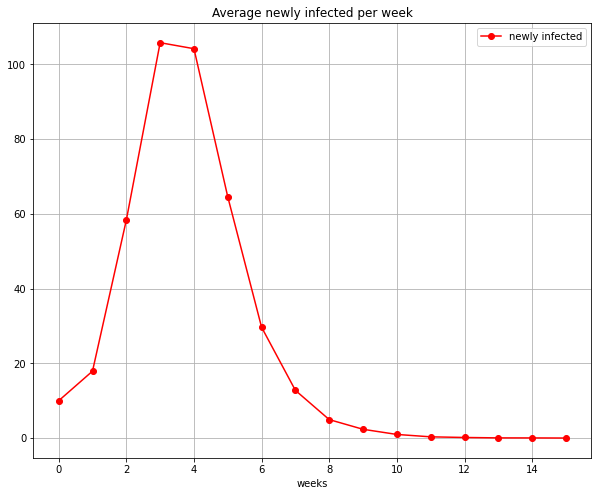

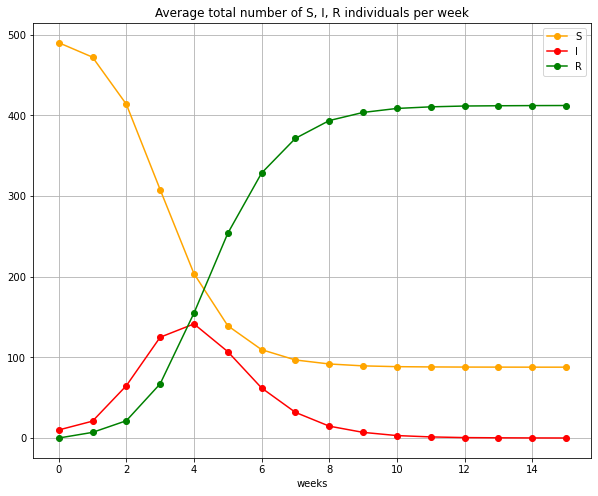

In [8]:
plot(states)

#### Problem 3

##### Simulate a pandemic with vaccination

Simulate the disease propagation for 15 weeks, but also distribute vaccination to the population.

This should be done so that the fraction of the population that has received the vaccine by each week is:
$$ Vacc(t) = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60] $$

At the end of each week find the number of individuals to vaccinate according to $Vacc(t)$ and then find individuals to vaccinate by selecting them uniformly at random from the population that has not received the vaccination yet. An infected individual might receive vaccination, if this happens we assume that an infected vaccinated is not able to infect others.

Generate a random graph with 500 nodes, the average degree should be $k=6$, let $\beta=0.3$ and $\rho=0.7$. 

Simulate the epidemic with vaccination for 15 weeks using the vaccination scheme $Vacc(t)$, starting from an initial configuration with 10 infected nodes chosen at random from the node set $V$.

The simulation follows exactly the same steps as before, but this time there are 4 possible states, so the transition matrix changes as a consequence.

As stated in the exercise, the probability that a node that is not vaccinated becomes Vaccinated is uniform, so at each time step a number of people decided by the vaccination rate vector is choosed uniformly at random from the people that are not vaccinated.

This means that for each node in states S and I there is a probability of transitioning to state V at step t that depends on the percentage of people that gets vaccinated in that time step and on the people that still need to be vaccinated.

In [26]:
k=6
N = 500

beta = 0.3
rho = 0.7
steps = 15
runs = 100
first_infections = 10
vaccination=[0, 0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]

G = random_graph(k, N)

states = np.zeros((runs, steps+1, len(G.nodes)))

for run in range(runs):
    #initialize the states of all the individuals 
    node_state = np.zeros(len(G.nodes))
    #select a random configuration with 10 infected nodes
    infected = np.zeros(first_infections)
    infected = choice(list(G.nodes), first_infections, replace=False)
    node_state[infected]=1
    
    states[run,0]=node_state
    
    for step in range(1, steps+1):
        
        #generate a probability matrix
        prob=np.zeros((len(G.nodes), 4))
        for i in range(len(node_state)):
            if node_state[i]==0:
                n_i = (node_state[list(G.neighbors(i))] == 1).sum()#number of neighbors of node i
                prob[i][0] = (1-beta)**n_i
                prob[i][1] = 1-prob[i][0]
            elif node_state[i] == 1:
                prob[i][1]=1-rho
                prob[i][2]=rho
            elif node_state[i]==2:
                prob[i][2]=1
            else:
                #if a node is vaccinated its state does not change when encountering other nodes
                prob[i][3]=1
        #for each time step apply the changes in the states of the nodes       
        node_state=np.array([choice(4, p=row) for row in prob])
        
        #compute the percentage of people to vaccinate in the interval between this step and the last one
        percentage=vaccination[step]-vaccination[step-1]        
        to_vaccinate=np.where(node_state != 3)[0]
        
        #at each time step administer the vaccines randomly
        #in this case it is a mutation
        new_vaccinated=choice(to_vaccinate,round(len(G.nodes)*percentage/100),replace=False)
        node_state[new_vaccinated]=3
        #record the state of the network for this time step
        states[run,step]=node_state
            
        
        

In [27]:
#add the vaccinated state to the plots
def plot_vax(matrix):
        new_infected = np.mean([np.logical_and(matrix[:, i-1] == 0, matrix[:, i] == 1).sum(axis = 1) for i in range(1, steps+1)], axis = 1)
        new_infected= np.append(first_infections,new_infected)
        new_vaccinated= np.mean([np.logical_and(matrix[:, i-1] !=3, matrix[:, i] == 3).sum(axis = 1) for i in range(1, steps+1)], axis = 1)

        susceptibles = [(matrix[:,w] == 0).sum()/runs for w in range(steps+1)]
        infected = [(matrix[:,w] == 1).sum()/runs for w in range(steps+1)]
        recovered = [(matrix[:,w] == 2).sum()/runs for w in range(steps+1)]
        vaccinated= [(matrix[:,w] == 3).sum()/runs for w in range(steps+1)]
        
        plt.figure(1, figsize=(10,8))
        plt.plot(new_infected,color="red",label="newly infected", marker='o')
        plt.plot(new_vaccinated,color="violet",label="newly vaccinated", marker='o')

        
        plt.xlabel("weeks")
        plt.legend()
        plt.grid()
        plt.title("Newly infected and newly vaccinated")
        
        plt.figure(2, figsize=(10,8))
        plt.plot(infected,color="red",label = "I", marker='o')
        plt.plot(susceptibles,color="orange",label= "S", marker='o')
        plt.plot(recovered,color="green",label = "R", marker='o')
        plt.plot(vaccinated,color="violet",label= "V", marker='o')

        
        plt.xlabel("weeks")
        plt.legend()
        plt.grid()
        plt.title("Average total number of S, I, R individuals per week")

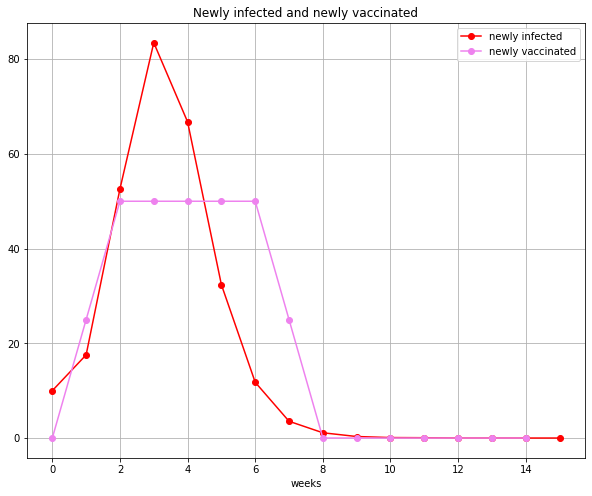

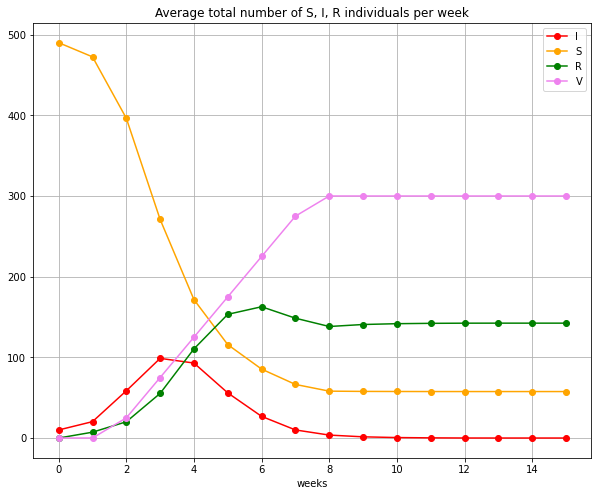

In [28]:
plot_vax(states)

#### Problem 4

##### The H1N1 pandemic in Sweden 2009

Simulate the pandemic between week 42-2009 and week 5-2010.

During these weeks the fraction of the population that had received the vaccine was:
$$ Vacc(t)=[5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60] $$

The population during the simulation will be $ n = |V| = 934 $ (population of Sweden scaled down by $10^4$)

For the scaled version the number of newly infected individuals each week between week 42-2009 and week 5-2010 was:
$$ I_0(t)=[1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0] $$

Estimate the average degree k and the disease spread parameters $\beta$ and $\rho$ that yield the lowest RMSE computed betweek the average of newly infected individuals according to the simulation and the true value $I_0$

In [12]:
#make a function for the simulation of an epidemic with vaccination from point 3
def epidemic_vax(k, N, G, beta, rho, runs, steps, first_infections, vaccination):
    
    vaccination=np.append(0,vaccination)
    states = np.zeros((runs+1, steps+1, len(G.nodes)))

    for run in range(runs):
        #initialize the states of all the individuals 
        node_state = np.zeros(len(G.nodes))
        #select a random configuration with a number of infected nodes
        infected = np.zeros(first_infections)
        infected = choice(list(G.nodes), first_infections, replace=False)
        node_state[infected]=1

        states[run,0]=node_state

        for step in range(1, steps+1):

            #generate a probability matrix
            prob=np.zeros((len(G.nodes), 4))
            for i in range(len(node_state)):
                if node_state[i]==0:
                    n_i = (node_state[list(G.neighbors(i))] == 1).sum()#number of neighbors of node i
                    prob[i][0] = (1-beta)**n_i
                    prob[i][1] = 1-prob[i][0]
                elif node_state[i] == 1:
                    prob[i][1]=1-rho
                    prob[i][2]=rho
                elif node_state[i]==2:
                    prob[i][2]=1
                else:
                    #if a node is vaccinated its state does not change when encountering other nodes
                    prob[i][3]=1
            #for each time step apply the changes in the states of the nodes       
            node_state=np.array([choice(4, p=row) for row in prob])

            #compute the percentage of people to vaccinate in the interval between this step and the last one
            percentage=vaccination[step]-vaccination[step-1]        
            to_vaccinate=np.where(node_state != 3)[0]

            #at each time step administer the vaccines randomly
            #in this case it is a mutation
            new_vaccinated=choice(to_vaccinate,round(len(G.nodes)*percentage/100),replace=False)
            node_state[new_vaccinated]=3
            #record the state of the network for this time step
            states[run,step]=node_state
            
    return states

This is in the end an optimization problem that we will solve by trying many of the possible combinations of parameters.

We have three parameters: $ \beta , \rho , k$

We use a set of three increments that are the values by which the parameters can increase or decrease

For every iteration we create a grid of all the possible combination of parameters given all the possible delta increments (decrements), starting from a set of parameters which is an initial guess.
In this case we have $3^3=27$ combinations of parameters

We perform 27 simulations and choose the the configuration of parameters that yielded the lowest RMSE out of the 27 tried.

In the following iteration we use as a starting point for the parameters the best configuration obtained from the previous iteration and repeat the procedure.

If the same configuration is selected in two different iterations as the configuration that yields the lowest RMSE, the algorithm stops and that configuration is returned as the set of best parameters.

In [18]:
def best_parameters(params, delta, N, first_infections, runs, steps, vaccination, I0):
    
    
    iteration_cnt = 0
    best_config=[]

    while True: 
        iteration_cnt += 1
        print("iteration: ", iteration_cnt)
        # record the rmse for each possible params configuration
        rmse = np.zeros(len(params)**3) # 27 confs
        
        # generate the 27 possible parameters configurations
        param_grid = {key:np.ones(3)*params[key]-np.array([-1,0,1])*delta[key] for key in params.keys()} 
        paramGrid = np.array(ParameterGrid(param_grid))

        for i, configuration in enumerate(paramGrid):            
            
            print('* ', end="")                      
            #define the parameters for the current simulation        
            rho =  configuration['rho'] 
            beta = configuration['beta']
            k = int(configuration['k']) 
            
            #probabilities cannot have values greater than 1 or lower than 0
            if rho>1 or beta>1:
                continue
            if rho<0 or beta<0:
                continue
                
            #build a random graph (seed is fixed)
            G = random_graph(k, N)
            
            # simulate the epidemic spread
            matrix = epidemic_vax(k, N, G, beta, rho, runs, steps, first_infections, vaccination)
            newly_infected=np.mean([np.logical_and(matrix[:, j-1] == 0, matrix[:, j] == 1).sum(axis = 1) for j in range(0, steps+1)], axis = 1)
            
            # record the rmse for the current simulation
            temp=np.sqrt(np.mean((newly_infected-I0)**2))
            rmse[i]=temp
            
        print()    
        
        # print the best results of the run
        conf_best_run = paramGrid[rmse.argmin()]
        rmse_best_run = rmse.min()
        
        print('best rmse: %.2f  '%(rmse_best_run), end="") 
        
        print('yielded by configuration: ', conf_best_run)

        for config in best_config:
            if np.array([conf_best_run[key] == config[key] for key in params.keys()]).sum() == 3:
                print()
                print('-------------------------------------------------------------------------')
                print()
                print("STOP - the best parameters are: ", config)
                return config
            
        best_config.append(conf_best_run)
            
        params = cp.copy(conf_best_run)
        print()

In [19]:
vaccination = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]) 
I_0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])
initial_params = {'k': 5, 'rho': 0.3, 'beta':0.3}
d = {'k': 1, 'rho': 0.1, 'beta':0.1}
N = 934
first_infections = 1
runs = 10
steps = 15

parameters = best_parameters(initial_params, d, N, first_infections,  runs, steps, vaccination, I_0)

iteration:  1
* * * * * * * * * * * * * * * * * * * * * * * * * * * 
best rmse: 4.74  yielded by configuration:  {'beta': 0.19999999999999998, 'k': 6.0, 'rho': 0.3}

iteration:  2
* * * * * * * * * * * * * * * * * * * * * * * * * * * 
best rmse: 4.08  yielded by configuration:  {'beta': 0.3, 'k': 5.0, 'rho': 0.4}

iteration:  3
* * * * * * * * * * * * * * * * * * * * * * * * * * * 
best rmse: 4.08  yielded by configuration:  {'beta': 0.3, 'k': 5.0, 'rho': 0.4}

-------------------------------------------------------------------------

STOP - the best parameters are:  {'beta': 0.3, 'k': 5.0, 'rho': 0.4}


##### Simulate the model using the best parameters found by the algorithm

In [29]:
vaccination = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]) 

rho =  parameters['rho'] 
beta = parameters['beta']
k = int(parameters['k'])
N = 934
first_infections = 1
runs = 100
steps = 15

G = random_graph(k, N)

#states = epidemic_vax(k, N, G, beta, rho, runs, steps, first_infections, vaccination)
states = epidemic_vax(k, N, G, beta, rho, runs, steps, first_infections, vaccination)

##### Plot the the average number of newly infected individuals each week according to the model with the best parameters, compared to the true value

[ 0.          1.45544554  5.18811881 14.05940594 27.8019802  38.45544554
 39.41584158 32.93069307 21.51485149 13.9009901   8.88118812  6.47524752
  4.28712871  3.12871287  1.95049505  1.30693069]


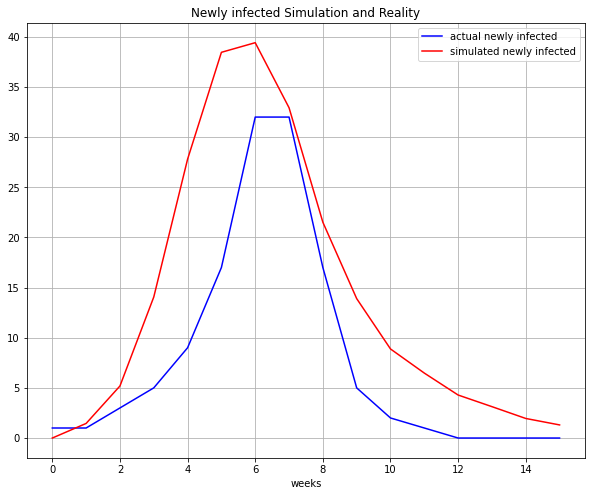

In [30]:
newly_infected=np.mean([np.logical_and(states[:, j-1] == 0, states[:, j] == 1).sum(axis = 1) for j in range(0, steps+1)], axis = 1)
I_0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])

plt.figure(1, figsize=(10,8))
plt.plot(I_0,color="blue",label="actual newly infected")
plt.plot(newly_infected,color="red",label="simulated newly infected")

plt.xlabel("weeks")
plt.legend()
plt.grid()
plt.title("Newly infected Simulation and Reality")

print(newly_infected)

##### Plot the total number of susceptible, infected, recovered and vaccinated individuals at each week according to the model with best parameters

Text(0.5, 1.0, 'Average total number of S, I, R individuals per week')

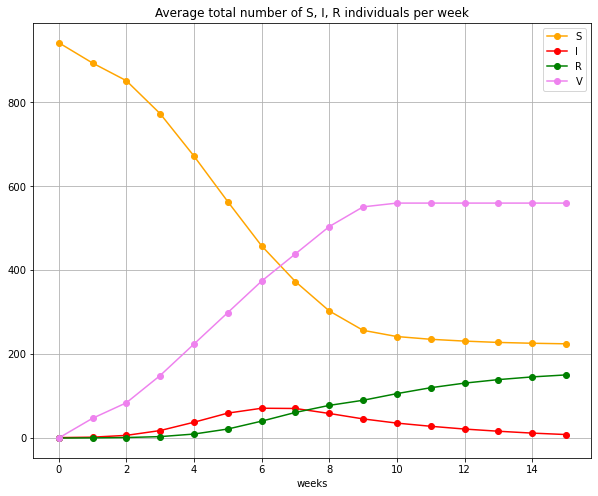

In [31]:
susceptibles = [(states[:,w] == 0).sum()/runs for w in range(steps+1)]
infected = [(states[:,w] == 1).sum()/runs for w in range(steps+1)]
recovered = [(states[:,w] == 2).sum()/runs for w in range(steps+1)]
vaccinated= [(states[:,w] == 3).sum()/runs for w in range(steps+1)]

plt.figure(2, figsize=(10,8))

plt.plot(susceptibles,color="orange",label= "S", marker='o')
plt.plot(infected,color="red",label = "I", marker='o')
plt.plot(recovered,color="green",label = "R", marker='o')
plt.plot(vaccinated,color="violet",label= "V", marker='o')


plt.xlabel("weeks")
plt.legend()
plt.grid()
plt.title("Average total number of S, I, R individuals per week")